# Notebook Playground

This notebook's goal is to get used to using OpenCV to work with basic images. It relies on images stored in the `data` directory.

I've taken photos of my desktop monitor displaying a checkerboard pattern, and hopefully can do some useful camera calibration stuff with OpenCV's functionality.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# My utility functions
from utils import *

# For timing tests
import time

Loading image Checkerboard/IMG_0821.jpg


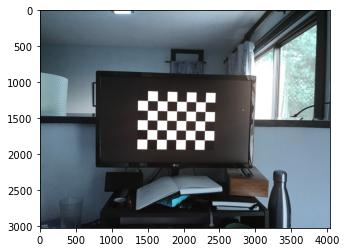

(3024, 4032, 3)
[[[0.3137255  0.3882353  0.44705883]
  [0.29411766 0.36862746 0.42745098]
  [0.2901961  0.3647059  0.42352942]
  [0.29411766 0.36862746 0.42745098]
  [0.27058825 0.34509805 0.40392157]]

 [[0.31764707 0.39215687 0.4509804 ]
  [0.29803923 0.37254903 0.43137255]
  [0.2901961  0.3647059  0.42352942]
  [0.28627452 0.36078432 0.41960785]
  [0.27058825 0.34509805 0.40392157]]

 [[0.34117648 0.41568628 0.4745098 ]
  [0.3254902  0.4        0.45882353]
  [0.30980393 0.38431373 0.44313726]
  [0.3019608  0.3764706  0.43529412]
  [0.2901961  0.3647059  0.42352942]]

 [[0.35686275 0.43137255 0.49019608]
  [0.3529412  0.42745098 0.4862745 ]
  [0.34117648 0.41568628 0.4745098 ]
  [0.32156864 0.39607844 0.45490196]
  [0.30980393 0.38431373 0.44313726]]

 [[0.3529412  0.42745098 0.4862745 ]
  [0.35686275 0.43137255 0.49019608]
  [0.34901962 0.42352942 0.48235294]
  [0.32941177 0.40392157 0.4627451 ]
  [0.30980393 0.38431373 0.44313726]]]


In [2]:
img_name = "Checkerboard/IMG_0821.jpg"
print(f"Loading image {img_name}")
image = load_image(img_name)
plt.imshow(image)
plt.show()
image = convert_image_c2f(image)
print(image.shape)
print(image[0:5, 0:5, :])

In [3]:
files = glob_data("Checkerboard/*.jpg")
for f in files:
    img = load_image(f)
    print(f"img.shape {img.shape}")

img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (4032, 3024, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (3024, 4032, 3)
img.shape (4032, 3024, 3)
img.shape (3024, 4032, 3)


## Image filters

`cv2.filter2D` is OpenCV's implementation of applying an image filter, such as a sobel filter, to an image. It can be an effective way to find edges in an image, depending on the kernel used.

A good source to learn about kernels is [Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing))

In [4]:
def edge_filter_pipeline(img_name):
    image = load_image(img_name, grayscale=True)
    image = convert_image_c2f(image)

    # Smooth the image with a gaussian blur to account for noise
    ksize = (0, 0) # zeros cause kernel size to be determined by sigma
    sigma = 10.0
    image_blurred = cv2.GaussianBlur(image, ksize, sigma)
    plt.imshow(image_blurred, cmap='gray')
    plt.show()

    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])
    image_edges = cv2.filter2D(image_blurred, -1, kernel)
    min_val = np.amin(image_edges)
    range_val = np.amax(image_edges - min_val) 
    image_edges = (image_edges - min_val) / range_val
    plt.imshow(image_edges, cmap='gray')
    plt.show()

    threshold = 0.70
    image_thresholded = np.where(image_edges > threshold, 1.0, 0.0)
    plt.imshow(image_thresholded, cmap='gray')
    plt.show()

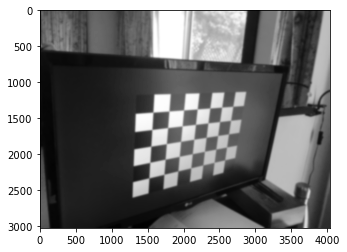

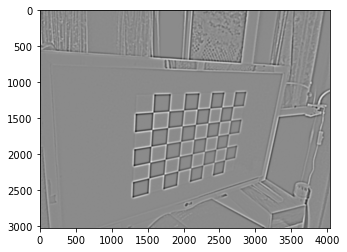

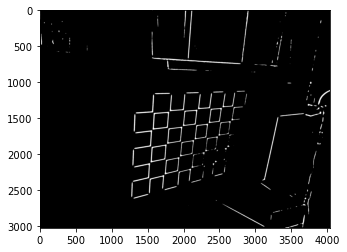

In [5]:
for f in files[6:7]:
    edge_filter_pipeline(f)

## Camera calibration using a checkerboard (or chessboard)

OpenCV uses the chessboard pattern to calibrate cameras.

It's all very complex and detailed, but lets give it a go!

In [6]:
# Constants related to camera checkerboard calibration.

# Checkerboard dimensions - number of internal corners (row, col)
PATTERN_SIZE = (5, 7)
PATTERN_NUM_POINTS = PATTERN_SIZE[0] * PATTERN_SIZE[1]

# Pixel refinement termination criteria - accuracy and number of iterations
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [7]:
def get_chessboard_corners(img_name, debug=False):
    """
    Tries to find the chessboard in the image given by img_name.
    Flag determines if should plot/debug result
    Returns:
        - ret: boolean success value
        - corners: subpixel coordinates of found corners, or None otherwise
    """
    image = load_image(img_name, grayscale=True)
    reversed_image = -image + 255
    
    ret, corners = cv2.findChessboardCorners(reversed_image, PATTERN_SIZE)
    
    if not ret:
        if debug:
            print(f"cv2.findChessboardCorners failed for {img_name}")
        return False, None

    corners2 = cv2.cornerSubPix(reversed_image, corners, (11, 11), (-1, -1), CRITERIA)
    
    if debug:
        plt.imshow(image,cmap='gray')
        plt.scatter(corners2[:,0,0], corners2[:,0,1], c='y', marker='.')
        plt.show()

    return ret, corners


In [8]:
horizontal_image_paths = []
image_shape = None
for f in files[:]:
    image = load_image(f)
    if image.shape[0] < image.shape[1]:
        image_shape = image.shape[:2]
        horizontal_image_paths.append(f)
    else:
        print(image.shape)


(4032, 3024, 3)
(4032, 3024, 3)


In [9]:
# Calibration goal: Run cv2.calibrateCamera to get the intrinsic parameters
# Construct a list of object points representing the internal corners of the checkerboard
objp = np.zeros((PATTERN_NUM_POINTS, 3), np.float32)
objp[:,:2] = np.mgrid[0:PATTERN_SIZE[0],0:PATTERN_SIZE[1]].T.reshape(-1, 2)

# Requires the following parameters:
objpoints = [] # list of objp, representing the 3d coordinates of our corners
imgpoints = [] # List of the found 2d corners in each image plane
image_size = image_shape[::-1]
camera_matrix = None # Initial guess for camera matrix, and output param
distortion_coeffs = None

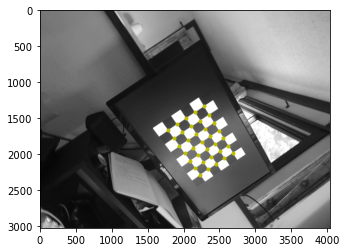

Got corners? True
Corners got: [[[1780.8011 1666.9929]]

 [[1905.0151 1584.14  ]]

 [[2029.7709 1500.8254]]

 [[2153.7063 1418.0618]]

 [[2278.7195 1334.89  ]]

 [[1860.4108 1778.4397]]

 [[1983.3274 1695.5554]]

 [[2105.157  1613.8696]]

 [[2227.57   1532.325 ]]

 [[2350.112  1450.6606]]

 [[1938.3698 1885.4445]]

 [[2058.437  1804.1844]]

 [[2178.7197 1723.3634]]

 [[2298.9543 1642.9352]]

 [[2420.0154 1562.8749]]

 [[2013.3934 1989.7625]]

 [[2131.985  1909.3942]]

 [[2250.1763 1829.7363]]

 [[2368.9368 1750.6027]]

 [[2487.8035 1671.614 ]]

 [[2086.8345 2090.967 ]]

 [[2203.2483 2011.766 ]]

 [[2320.1904 1933.1444]]

 [[2436.7014 1855.1173]]

 [[2554.442  1777.4619]]

 [[2157.0522 2188.8472]]

 [[2273.039  2111.0176]]

 [[2387.559  2033.7362]]

 [[2503.4312 1956.637 ]]

 [[2618.7097 1880.1116]]

 [[2227.168  2284.464 ]]

 [[2339.806  2207.6396]]

 [[2454.046  2131.4392]]

 [[2567.3406 2055.568 ]]

 [[2682.145  1979.6461]]]


In [10]:
ret, corners = get_chessboard_corners(horizontal_image_paths[0], debug=True)
print(f"Got corners? {ret}")
print(f"Corners got: {corners}")

In [11]:

average_delta_time = 0.0

num_imgs = len(horizontal_image_paths)
for f in horizontal_image_paths:
    img_start_time = time.time()
    ret, corners = get_chessboard_corners(f)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    img_end_time = time.time()
    average_delta_time += (img_end_time - img_start_time)/num_imgs
    print(f"Image {f} took {img_end_time - img_start_time} seconds to get corners")

print(f"Average time per image: {average_delta_time} seconds")

Image ../data/Checkerboard/IMG_0841.jpg took 3.171536445617676 seconds to get corners
Image ../data/Checkerboard/IMG_0830.jpg took 0.11393499374389648 seconds to get corners
Image ../data/Checkerboard/IMG_0840.jpg took 0.12185120582580566 seconds to get corners
Image ../data/Checkerboard/IMG_0834.jpg took 67.82787299156189 seconds to get corners
Image ../data/Checkerboard/IMG_0821.jpg took 0.12784814834594727 seconds to get corners
Image ../data/Checkerboard/IMG_0846.jpg took 85.47392201423645 seconds to get corners
Image ../data/Checkerboard/IMG_0833.jpg took 99.60011553764343 seconds to get corners
Image ../data/Checkerboard/IMG_0825.jpg took 0.10620284080505371 seconds to get corners
Image ../data/Checkerboard/IMG_0826.jpg took 99.2738585472107 seconds to get corners
Image ../data/Checkerboard/IMG_0824.jpg took 0.0820000171661377 seconds to get corners
Image ../data/Checkerboard/IMG_0845.jpg took 49.76566028594971 seconds to get corners
Image ../data/Checkerboard/IMG_0832.jpg took 5

In [12]:
start_time = time.time()

calibration_start_time = time.time()
ret, intrinsic_mat, distortion_mat, rotation_vecs, translation_vecs = \
    cv2.calibrateCamera(objpoints, imgpoints, image_size, camera_matrix, distortion_coeffs)
end_time = time.time()

print(f"Calibration took {end_time - calibration_start_time} seconds")
print(f"Total time: {average_delta_time * num_imgs + end_time - start_time} seconds")


Calibration took 0.2602405548095703 seconds
Total time: 809.5300986766815 seconds


In [13]:
print(intrinsic_mat)
print(distortion_mat)
numpy_save("numpy/intrinsic_mat.npy", intrinsic_mat)
numpy_save("numpy/distortion_mat.npy", distortion_mat)

[[3.30897028e+03 0.00000000e+00 2.02054204e+03]
 [0.00000000e+00 3.30790115e+03 1.48212962e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 3.04467388e-01 -2.12963226e+00 -2.46466929e-03 -4.77626663e-04
   4.89513643e+00]]


Original


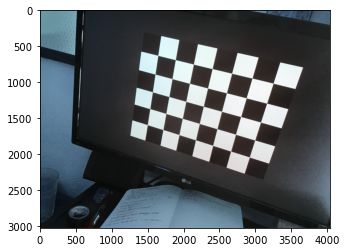

Undistorted


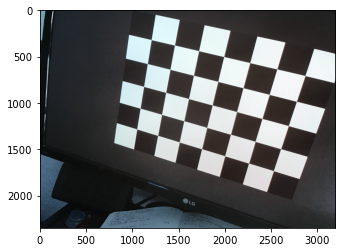

In [14]:
img = load_image(horizontal_image_paths[1])
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(intrinsic_mat, distortion_mat, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, intrinsic_mat, distortion_mat, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
print("Original")
plt.imshow(img)
plt.show()

print("Undistorted")
plt.imshow(dst)
plt.show()